In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.utils import resample

#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6


def Normalize(df):
    df_Norm = (df - df.mean())/df.std()
    return df_Norm

def AgeGroup(row):
    if row <= 5:
        return "0 to 5"
    if 5 < row <= 10:
        return "5 to 10"
    if 10 < row <= 15:
        return "10 to 15"
    if 15 < row <= 20:
        return "15 to 20"
    if 20 < row <= 25:
        return "20 to 25"
    if 25 < row <= 30:
        return "25 to 30"
    if 30 < row <= 40:
        return "30 to 40"
    else:
        return "> 40"
    
def HeightGroup(row):
    if row <= 3:
        return "0 to 3"
    if 3 < row <= 4:
        return "3 to 4"
    if 4 < row <= 5:
        return "4 to 5"
    if 5 < row <= 6:
        return "5 to 6"
    if 6 < row <= 8:
        return "6 to 8"
    else:
        return "> 8"

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


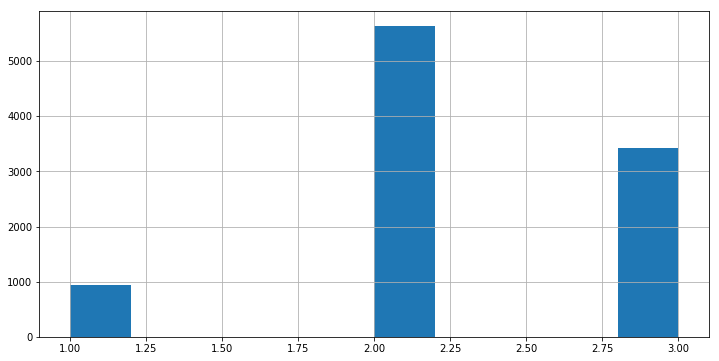

In [2]:
df = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_values.csv")
damages = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_labels.csv")
joined = df.set_index("building_id").join(damages.set_index("building_id"))

joined["area/height"] = joined["area"]/joined["height"]
joined.reset_index(inplace = True)

joined["damage_grade"].hist()
plt.show()

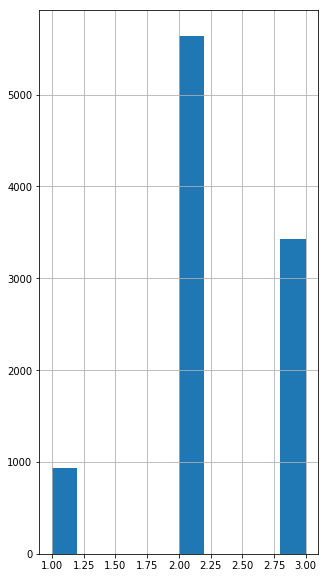

In [21]:
df = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_values.csv")
damages = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_labels.csv")

joined = df.set_index("building_id").join(damages.set_index("building_id"))


#joined = joined[joined["age"] < 100]
#joined = joined[joined["height"] < 15]
#joined = joined[joined["area"] < 200]
joined["age_group"] = joined["age"].apply(lambda x: AgeGroup(x) )
joined["height_group"] = joined["height"].apply(lambda x: HeightGroup(x) )

dfH_Norm = Normalize(pd.DataFrame(joined["height"]))
dfArea_Norm = Normalize(pd.DataFrame(joined["area"]))
dfAge_Norm = Normalize(pd.DataFrame(joined["age"]))


joined["height_n"] = dfH_Norm["height"]
joined["area_n"] = dfArea_Norm["area"]
joined["age_n"] = dfAge_Norm["age"]


columns = [
    #"age",
    #"height",
    #"area",
    #"age_n",
    #"height_n",
    #"age_group",
    #"height_group",
    #"area_n",
    "count_families",
    "count_floors_pre_eq",
    #"foundation_type",
    #"ground_floor_type",
    "legal_ownership_status",
    "plan_configuration",
    "has_secondary_use_other",
    "has_secondary_use_agriculture",
    "has_secondary_use_hotel",
    "has_secondary_use_rental",
    "has_secondary_use_health_post",
    "has_secondary_use_gov_office",
    "has_secondary_use_school",
    "has_secondary_use_use_police",
    "has_secondary_use_industry",
    "has_secondary_use_institution",
    #"roof_type",
    #'has_superstructure_adobe_mud', 
    #'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    #'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]

joined.drop(columns,inplace=True,axis = 1)

joined.reset_index(inplace = True)

joined = pd.get_dummies(joined)

joined["damage_grade"].hist()
plt.show()

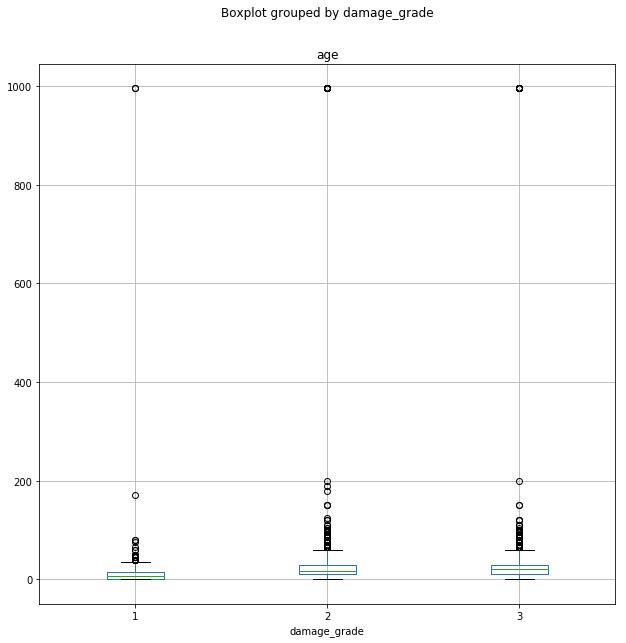

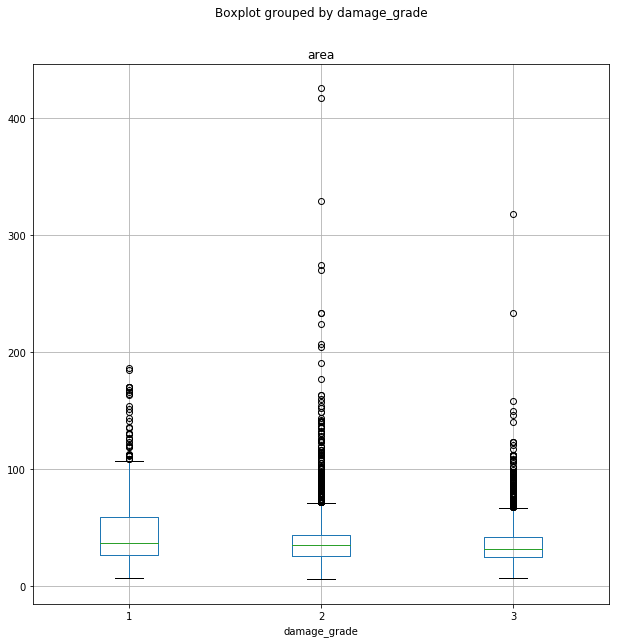

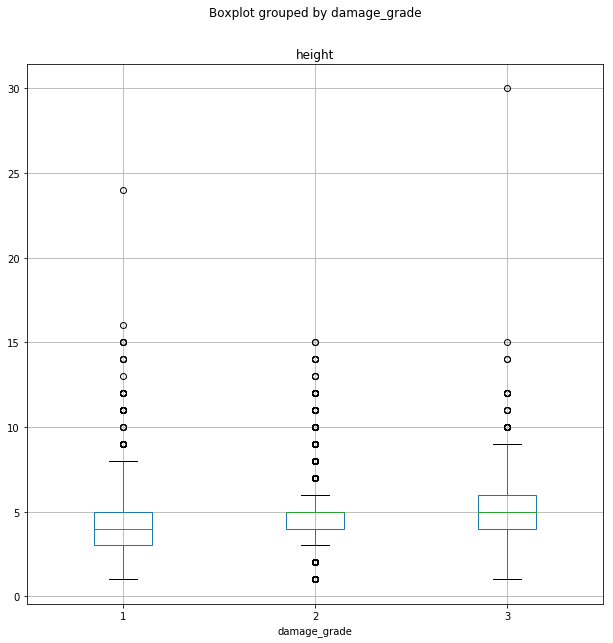

In [22]:
#remove outliers
for col in ['age', 'area', 'height']:
    fig, ax = plt.subplots(figsize=(10,  10))
    joined.boxplot(col,'damage_grade', ax)
    plt.show()

In [19]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain["damage_grade"])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['damage_grade'], cv=cv_folds, scoring='f1_micro')
    
    #Print model report:
    print("\nModel Report")
    print( "Accuracy : %.4g" % metrics.accuracy_score(dtrain['damage_grade'].values, dtrain_predictions))
    print( "Micro F1 : %.4g" % metrics.f1_score(dtrain['damage_grade'].values, dtrain_predictions,average='micro'))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['damage_grade'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

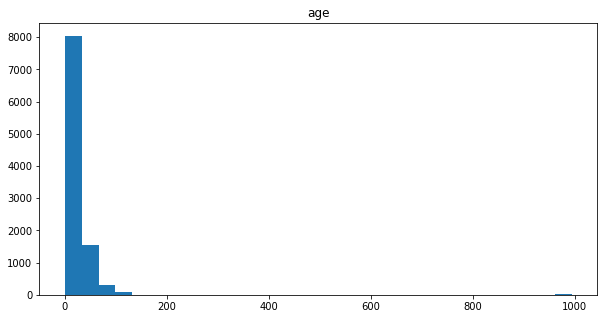

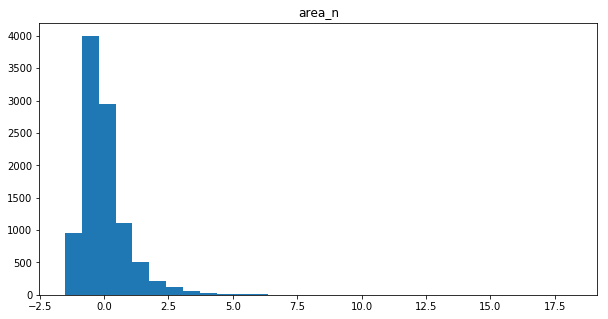

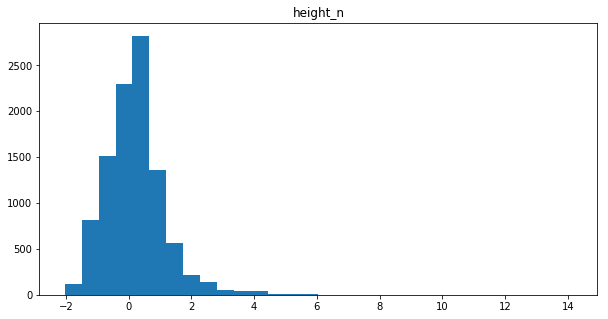

In [24]:
#remove outliers
for col in ['age', 'area_n', 'height_n']:
    fig, ax = plt.subplots(figsize=(10,  5))
    ax.hist(joined[col],bins = 30)
    plt.title(col)
    plt.show()

In [37]:
dfpvt = df.pivot(index = "geo_level_1_id",columns='damage_grade', values='building_id')
dfpvt.reset_index(inplace=True)
dfpvt.columns = ['geo_level_1_id',"damage_grade_1","damage_grade_2","damage_grade_3"]
dfpvt.head()

,geo_level_1_id,damage_grade_1,damage_grade_2,damage_grade_3
0,0,71.0,595.0,217.0
1,1,293.0,452.0,85.0
2,2,49.0,461.0,346.0
3,3,12.0,150.0,672.0
4,4,33.0,436.0,256.0


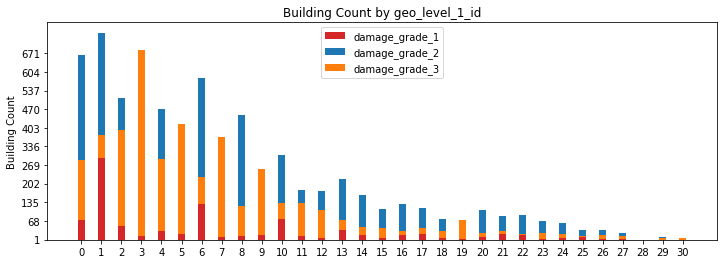

In [48]:
df = joined[["geo_level_1_id","damage_grade","building_id"]].groupby(["geo_level_1_id","damage_grade"]).count()
df.reset_index(inplace=True)

min_y = df["building_id"].min()
max_y = df["building_id"].max()


dfpvt = df.pivot(index = "geo_level_1_id",columns='damage_grade', values='building_id')
dfpvt.reset_index(inplace=True)

dfpvt.columns = ['geo_level_1_id',"damage_grade_1","damage_grade_2","damage_grade_3"]

N = dfpvt.shape[0]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, dfpvt["damage_grade_1"], width, color='#d62728')
p2 = plt.bar(ind, dfpvt["damage_grade_2"], width,bottom=dfpvt["damage_grade_1"])
p3 = plt.bar(ind, dfpvt["damage_grade_3"], width,bottom=dfpvt["damage_grade_1"])
#p2 = plt.bar(ind, dfpvt["damage_grade_2"], width)

plt.ylabel('Building Count')
plt.title('Building Count by geo_level_1_id')
plt.xticks(ind, dfpvt["geo_level_1_id"])
plt.yticks(np.arange(min_y, max_y+1, round(max_y/10.0)))
plt.legend((p1[0], p2[0], p3[0]), ('damage_grade_1', 'damage_grade_2','damage_grade_3'))

In [92]:
def PlotFrequencies(data,col):
    df = joined[[col,"damage_grade","building_id"]].groupby([col,"damage_grade"]).count()
    df.reset_index(inplace=True)

    dfpvt = df.pivot(index = col,columns='damage_grade', values='building_id')
    dfpvt.reset_index(inplace=True)
    
    dfpvt.columns = [col,"damage_grade_1","damage_grade_2","damage_grade_3"]

    min_y = (dfpvt["damage_grade_1"] + dfpvt["damage_grade_2"] + dfpvt["damage_grade_3"]).min()
    max_y = (dfpvt["damage_grade_1"] + dfpvt["damage_grade_2"] + dfpvt["damage_grade_3"]).max()
    N = dfpvt.shape[0]

    ind = np.arange(N)    # the x locations for the groups
    width = 0.5      # the width of the bars: can also be len(x) sequence
    
    fig, ax = plt.subplots()
    
    p1 = ax.bar(ind, dfpvt["damage_grade_1"], color='#809fff')
    p2 = ax.bar(ind, dfpvt["damage_grade_2"],color='#ffb399',bottom=dfpvt["damage_grade_1"])
    p3 = ax.bar(ind, dfpvt["damage_grade_3"],color='#e63900',bottom=dfpvt["damage_grade_2"] + dfpvt["damage_grade_1"])
    #p2 = plt.bar(ind, dfpvt["damage_grade_2"], width)

    plt.ylabel('Building Count')
    plt.title('Building Count by ' + col)
    plt.xticks(ind, dfpvt[col])
    plt.legend((p1[0], p2[0], p3[0]), ('damage_grade_1', 'damage_grade_2','damage_grade_3'))
    plt.show()

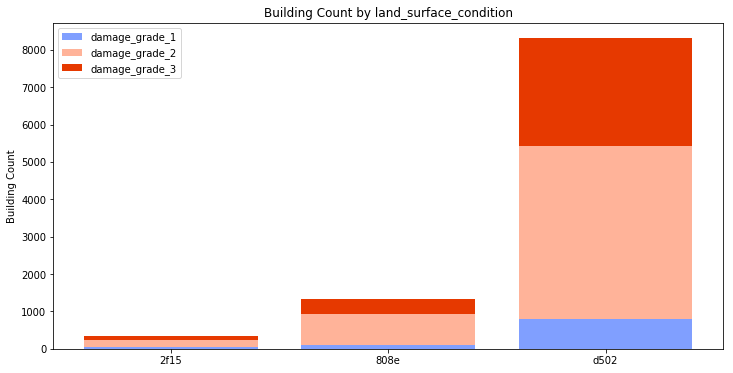

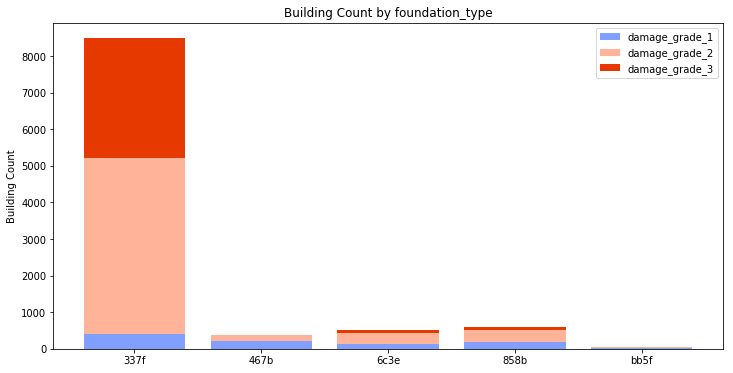

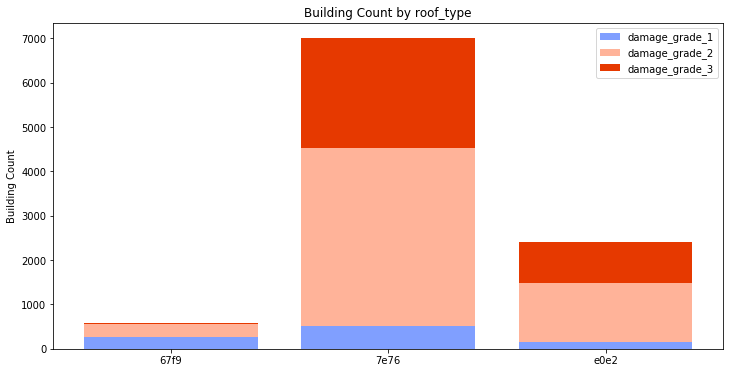

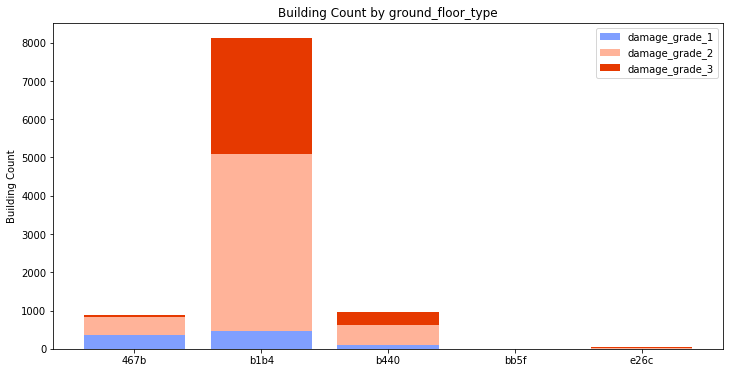

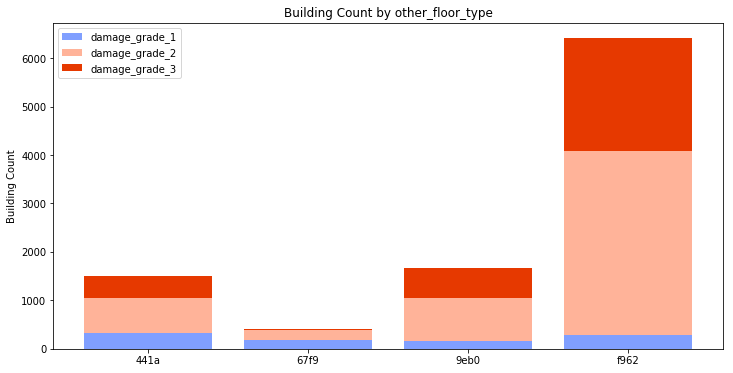

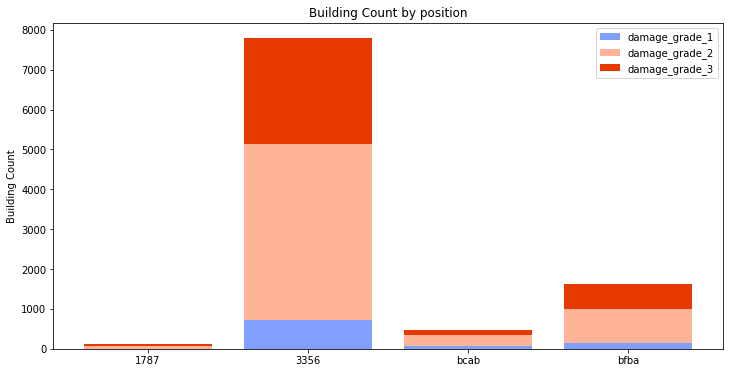

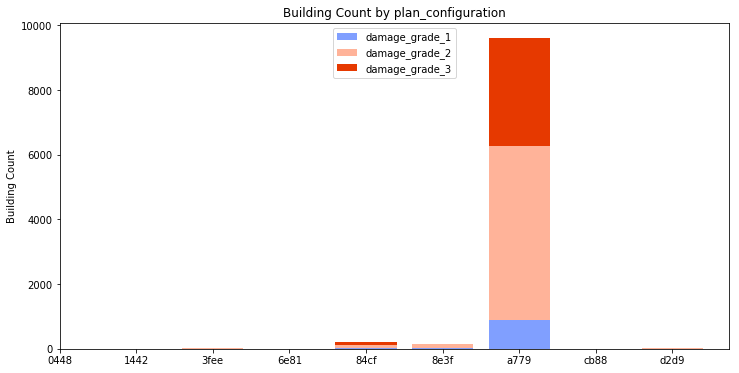

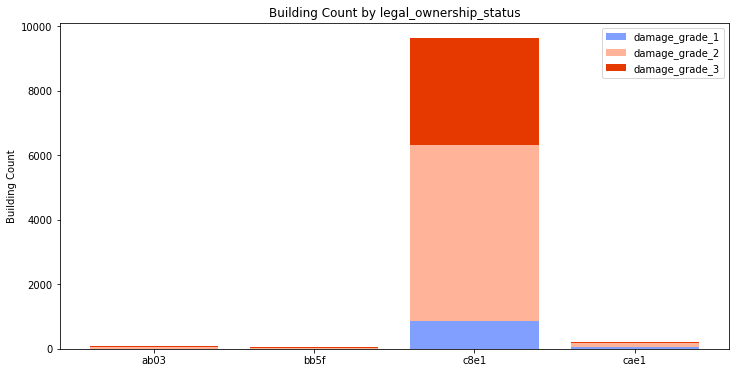

In [104]:
#predictors = [x for x in joined.columns if x not in ["damage_grade", "building_id","geo_level_2_id","geo_level_3_id"]]
predictors = ["land_surface_condition",
"foundation_type",
"roof_type",
"ground_floor_type",
"other_floor_type",
"position",
"plan_configuration",
"legal_ownership_status"]
for col in predictors:
    PlotFrequencies(joined,col)

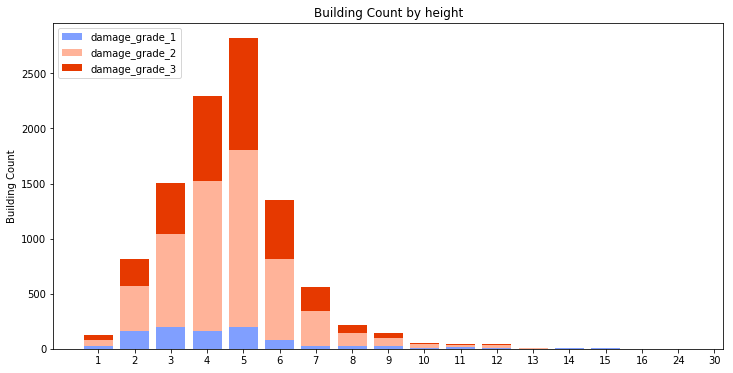

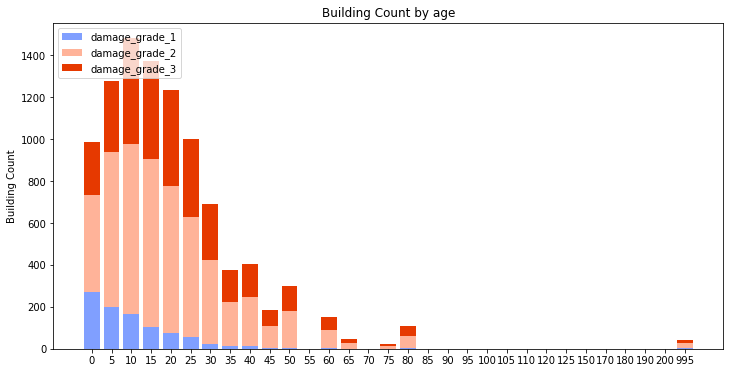

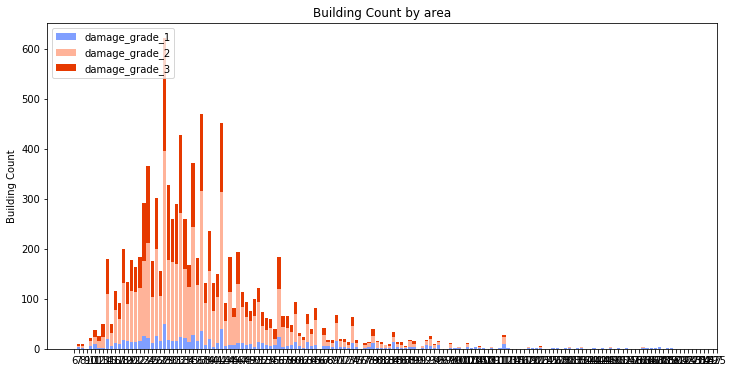

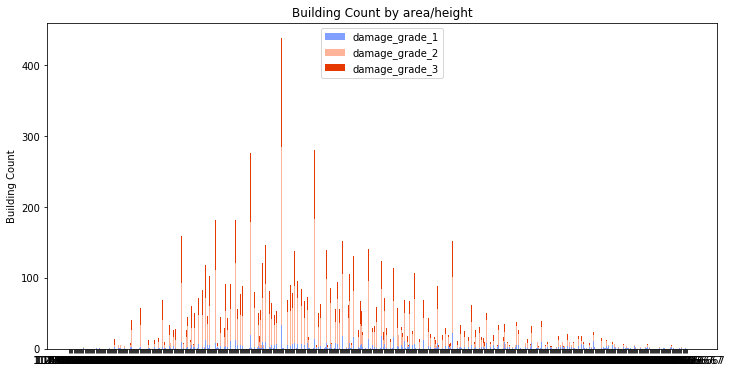

In [114]:
#predictors = [x for x in joined.columns if x not in ["damage_grade", "building_id","geo_level_2_id","geo_level_3_id"]]
predictors = [
    "height",
    "age",
    "area",
    "area/height"
    
]
for col in predictors:
    PlotFrequencies(joined,col)

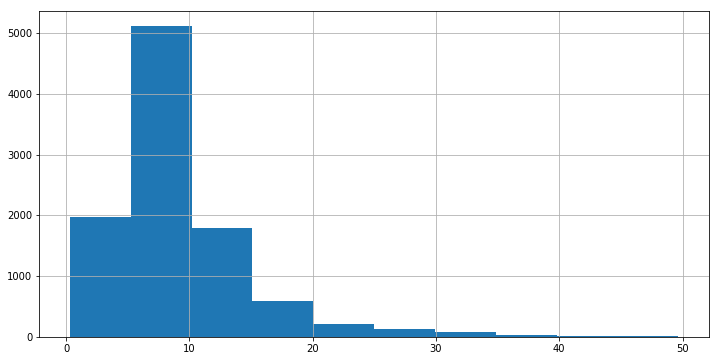

In [120]:
nooutliers = joined[joined["area/height"] < 50]
nooutliers["area/height"].hist()

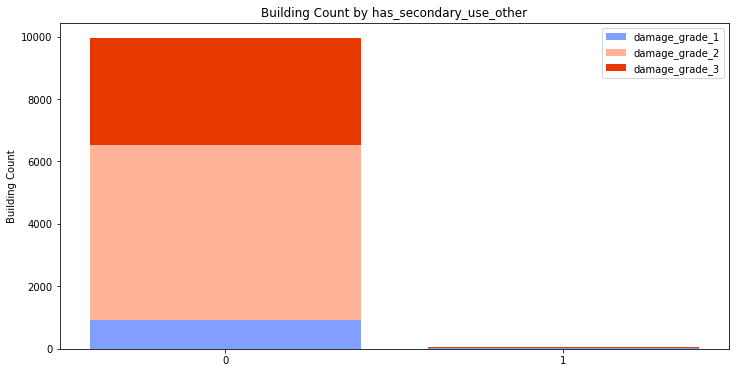

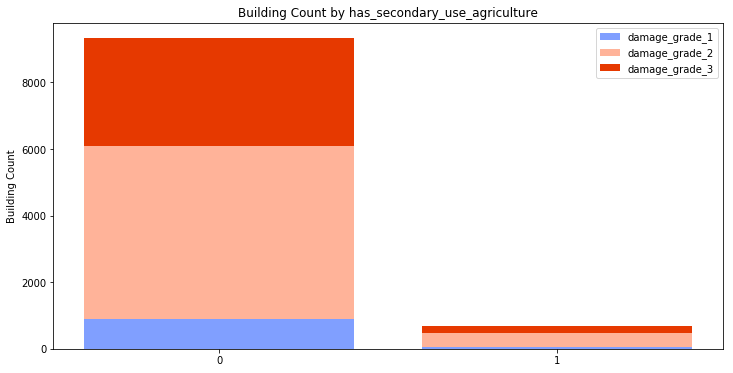

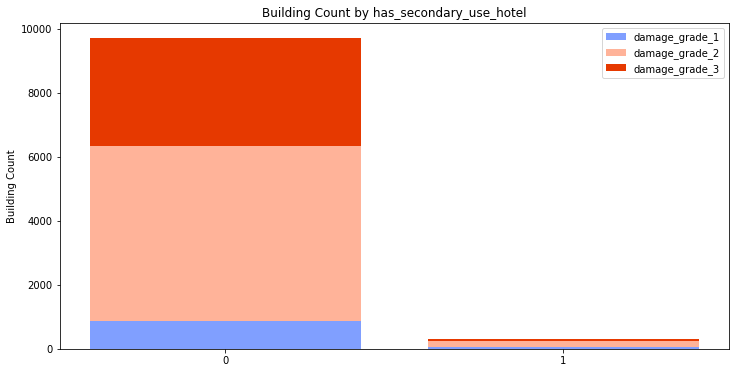

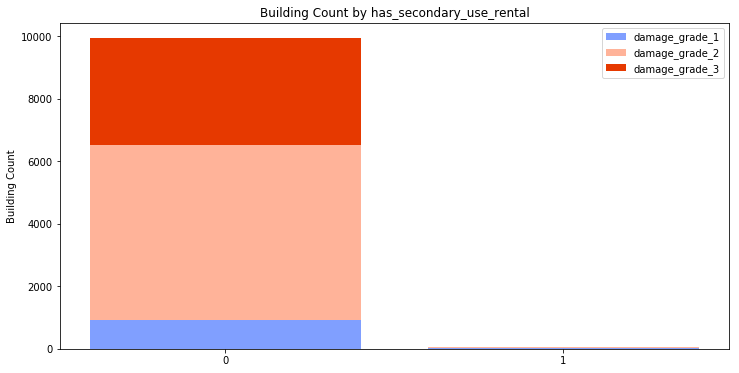

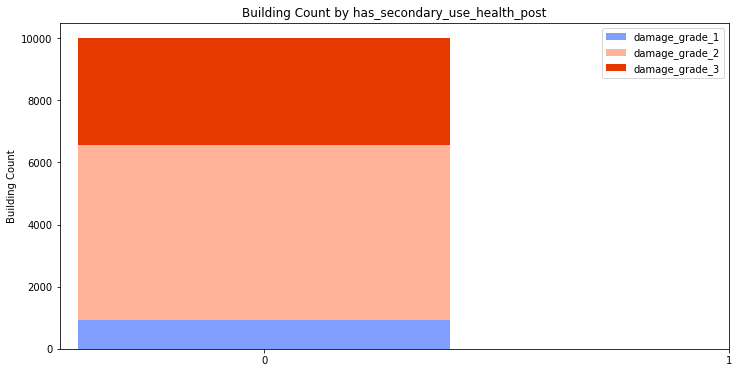

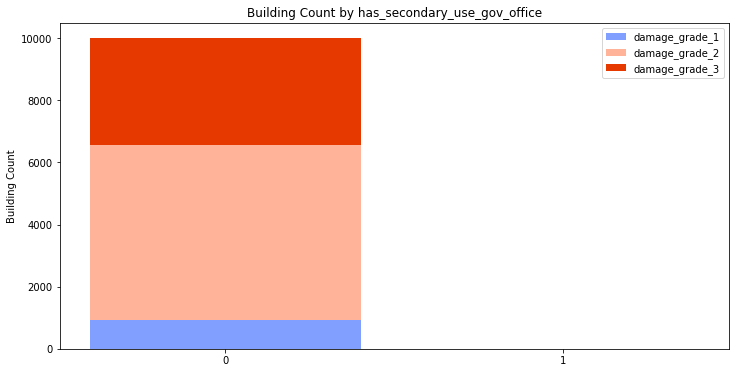

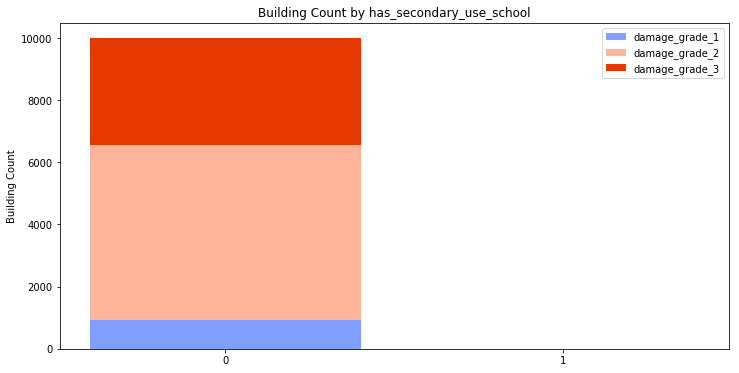

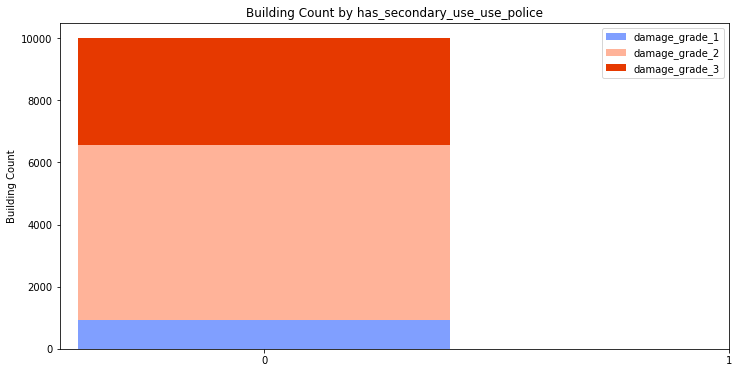

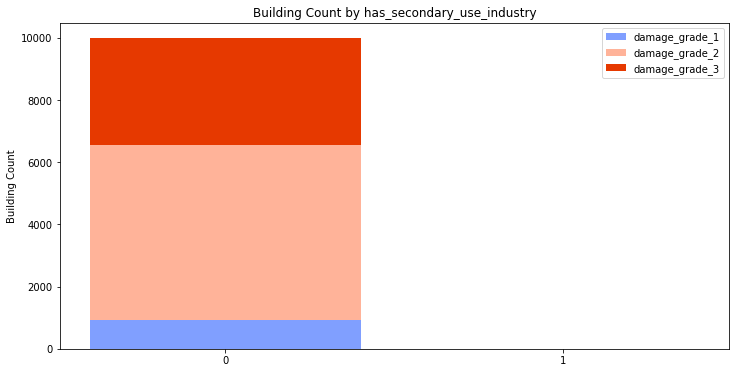

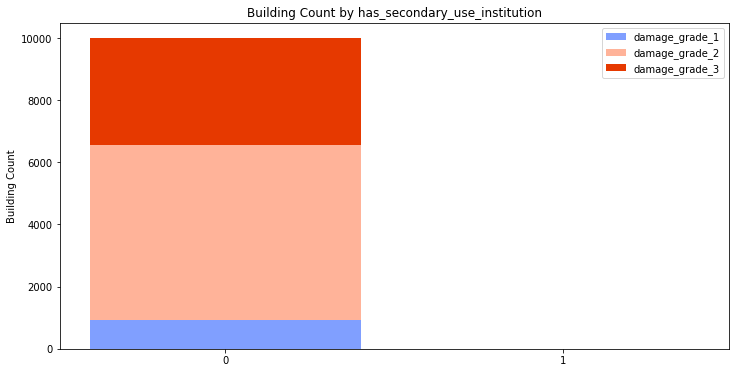

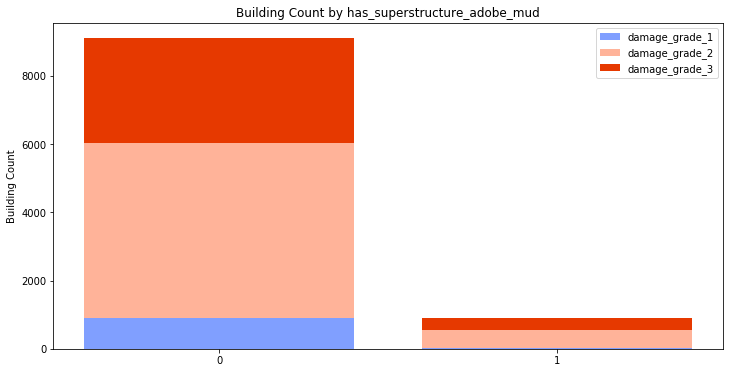

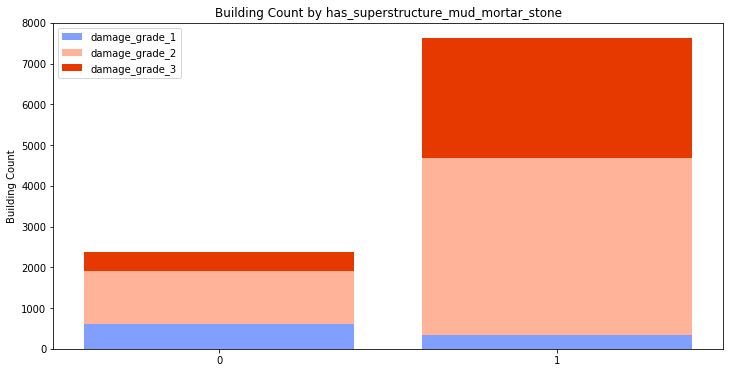

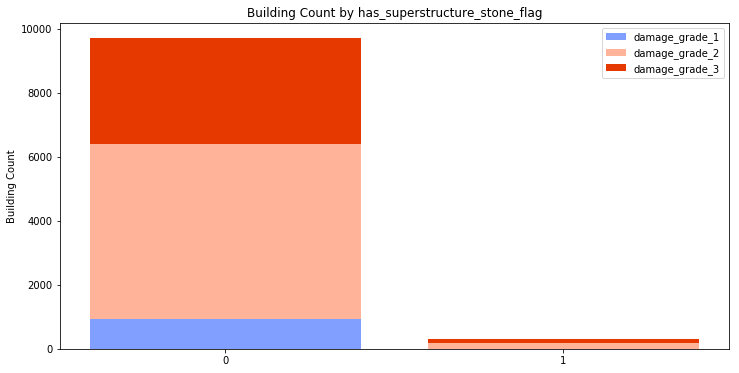

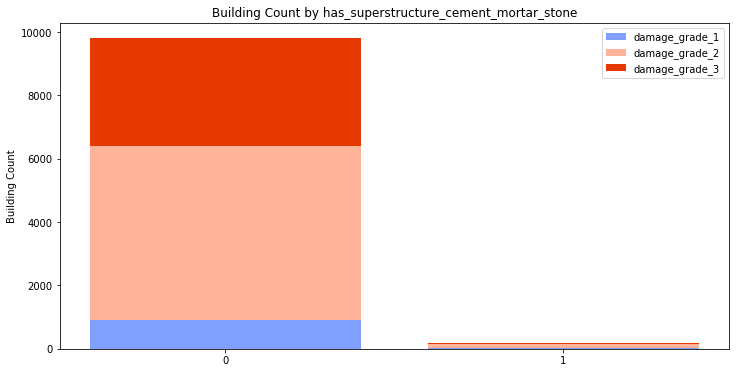

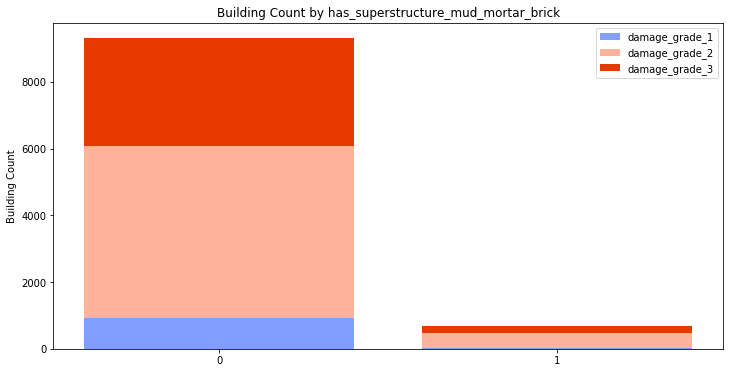

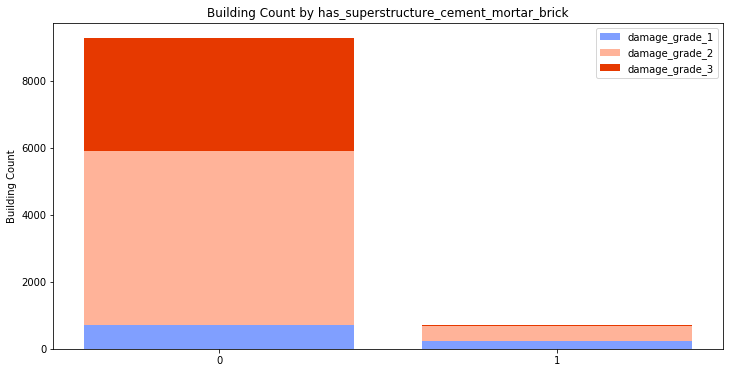

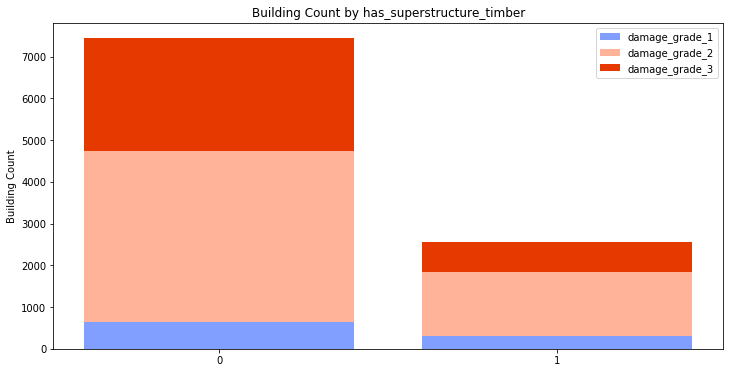

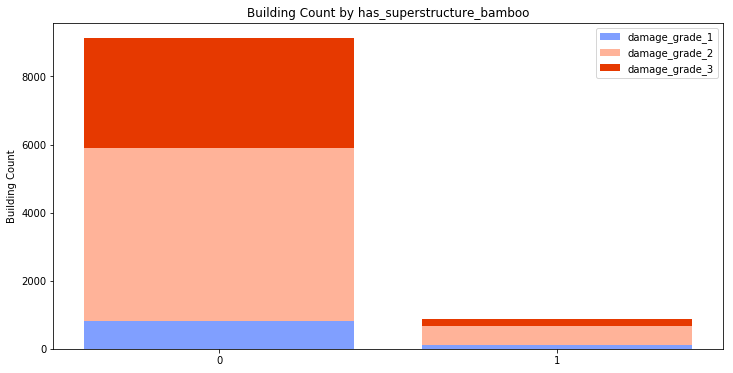

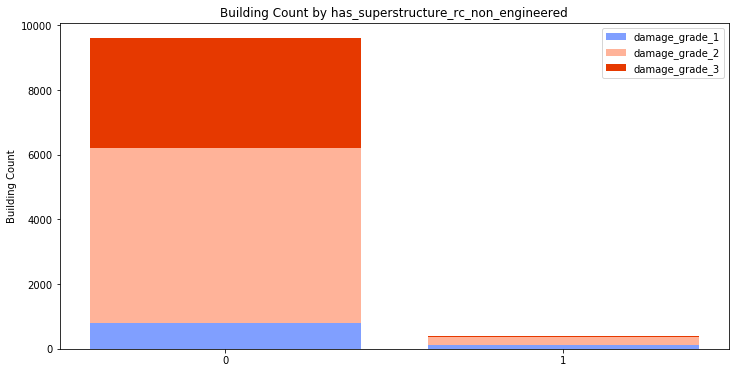

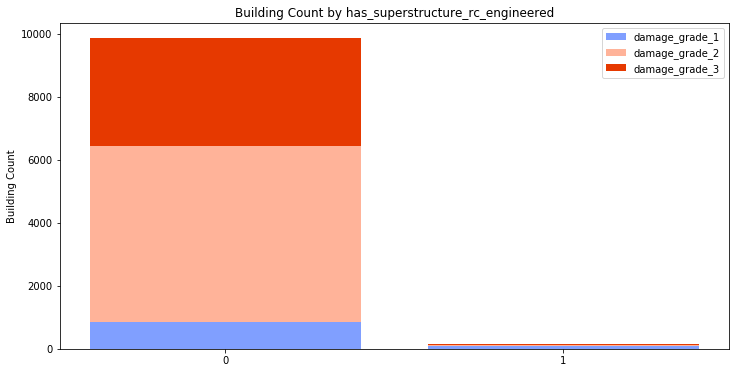

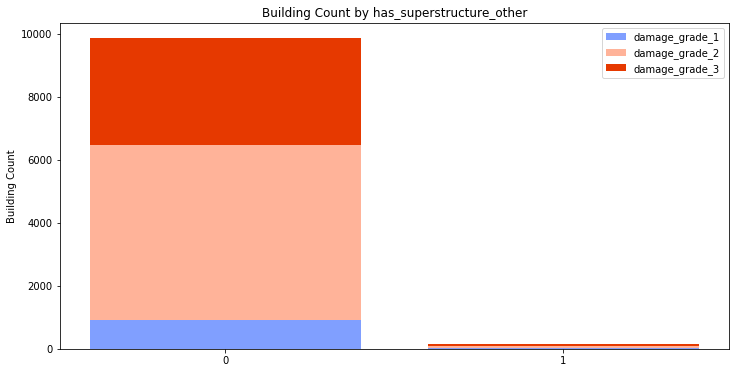

In [121]:
#predictors = [x for x in joined.columns if x not in ["damage_grade", "building_id","geo_level_2_id","geo_level_3_id"]]
predictors = [
    "has_secondary_use_other",
    "has_secondary_use_agriculture",
    "has_secondary_use_hotel",
    "has_secondary_use_rental",
    "has_secondary_use_health_post",
    "has_secondary_use_gov_office",
    "has_secondary_use_school",
    "has_secondary_use_use_police",
    "has_secondary_use_industry",
    "has_secondary_use_institution",
    'has_superstructure_adobe_mud', 
    'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 
    'has_superstructure_timber',
    'has_superstructure_bamboo', 
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 
    'has_superstructure_other'
]
for col in predictors:
    PlotFrequencies(joined,col)

In [126]:
df = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_values.csv")
damages = pd.read_csv("C:/DAT102X Microsoft Professional Capstone  Data Science/Data/Training_labels.csv")
joined = df.set_index("building_id").join(damages.set_index("building_id"))

joined["area/height"] = joined["area"]/joined["height"]
joined.reset_index(inplace = True)

joined["age_group"] = joined["age"].apply(lambda x: AgeGroup(x) )
joined["height_group"] = joined["height"].apply(lambda x: HeightGroup(x) )

dfH_Norm = Normalize(pd.DataFrame(joined["height"]))
dfArea_Norm = Normalize(pd.DataFrame(joined["area"]))
dfAge_Norm = Normalize(pd.DataFrame(joined["age"]))


joined["height_n"] = dfH_Norm["height"]
joined["area_n"] = dfArea_Norm["area"]
joined["age_n"] = dfAge_Norm["age"]



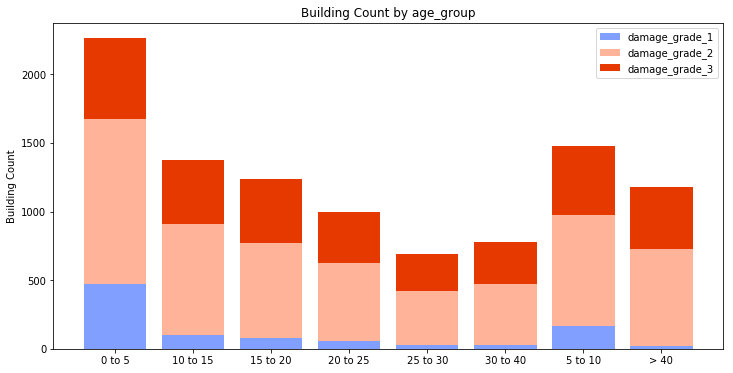

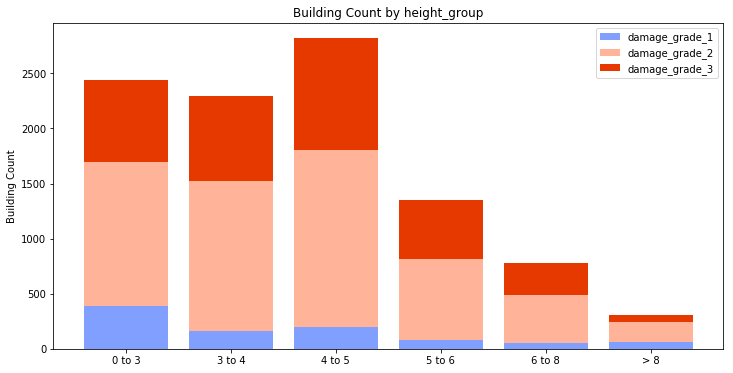

In [127]:
#predictors = [x for x in joined.columns if x not in ["damage_grade", "building_id","geo_level_2_id","geo_level_3_id"]]
predictors = [
    "age_group", 
    'height_group'
]
for col in predictors:
    PlotFrequencies(joined,col)